In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
)
from sklearn.metrics import ConfusionMatrixDisplay

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
churn = pd.read_csv("../data/data_set.csv", index_col="ID")

churn = churn.drop(columns=["Surname", "CustomerId"]) # These varaibles are not useful for our analysis

churn['Gender']=churn['Gender'].map({'Male':0, 'Female':1}) # To binary

churn = pd.get_dummies(churn, columns=['Geography'], drop_first=True, dtype=int) # One-hot encoding

churn[['HasCrCard', 'IsActiveMember', 'Exited', 'Gender']]=churn[['HasCrCard', 'IsActiveMember', 'Exited', 'Gender']].astype('category')
# To category


# Normalization
scaler = MinMaxScaler()
num_cols = churn.select_dtypes(include='number').columns
churn[num_cols] = scaler.fit_transform(churn[num_cols])


# Introduction

Ce projet s'inscrit dans la continuité de mon précédent travail intitulé **` Prédiction du désabonnement avec le ML – Partie 1 `**, où nous avons réalisé une analyse exploratoire des données et appliqué plusieurs modèles de machine learning de base tels que Random Forest, SVM et Decision Tree. Dans ce projet complémentaire, nous approfondissons notre approche en implémentant un modèle plus puissant et sophistiqué : **XGBoost**. Notre objectif est double : d'une part, entraîner le modèle XGBoost et optimiser ses paramètres pour améliorer ses performances prédictives ; d'autre part, appliquer **SHAP** (SHapley Additive ExPlanations) pour l'explicabilité du modèle. Ce faisant, nous cherchons à identifier les caractéristiques qui influencent le plus les prévisions de désabonnement du modèle, fournissant ainsi une compréhension plus approfondie du comportement des clients.

# Model Building


=== Model 1 Parameters: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 4} ===


/Users/eric/Documents/Formation/ML_School/Projets/projet_Bank_Churn/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:16:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.81      0.87     22658
           1       0.53      0.80      0.64      6058

    accuracy                           0.81     28716
   macro avg       0.74      0.81      0.76     28716
weighted avg       0.85      0.81      0.82     28716

ROC-AUC Score: 0.8898280920297891


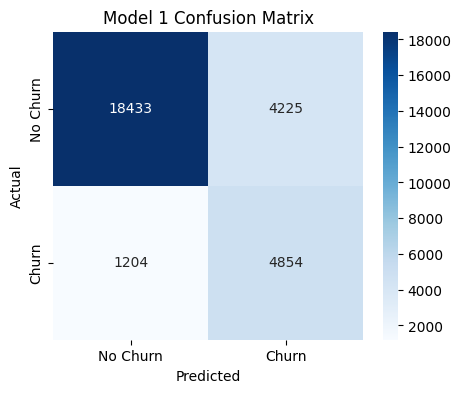

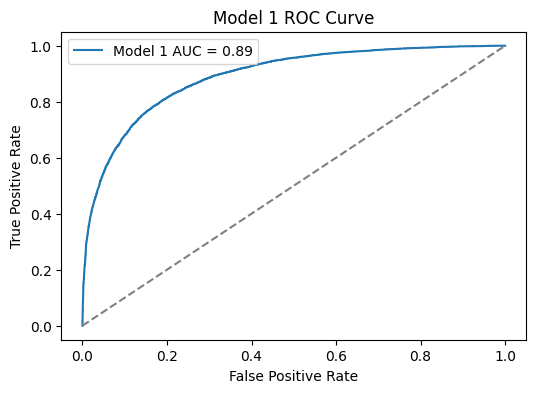


=== Model 2 Parameters: {'n_estimators': 150, 'learning_rate': 0.05, 'max_depth': 5} ===


/Users/eric/Documents/Formation/ML_School/Projets/projet_Bank_Churn/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:16:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.82      0.87     22658
           1       0.54      0.79      0.64      6058

    accuracy                           0.81     28716
   macro avg       0.74      0.81      0.76     28716
weighted avg       0.85      0.81      0.83     28716

ROC-AUC Score: 0.8901518884694257


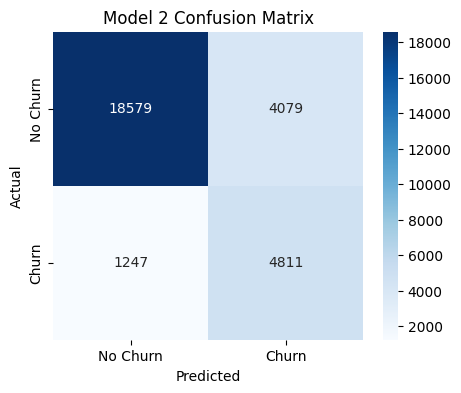

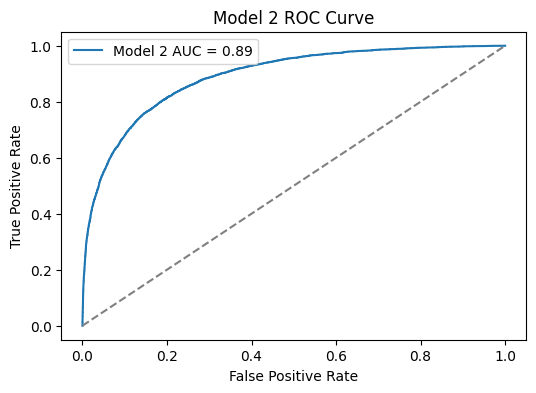


=== Model 3 Parameters: {'n_estimators': 200, 'learning_rate': 0.01, 'max_depth': 3} ===


/Users/eric/Documents/Formation/ML_School/Projets/projet_Bank_Churn/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:16:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.81      0.87     22658
           1       0.53      0.78      0.63      6058

    accuracy                           0.81     28716
   macro avg       0.73      0.80      0.75     28716
weighted avg       0.85      0.81      0.82     28716

ROC-AUC Score: 0.8787573027043344


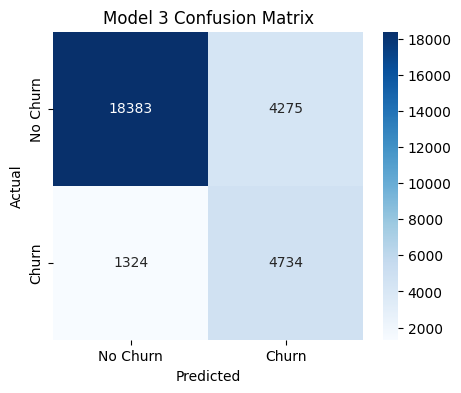

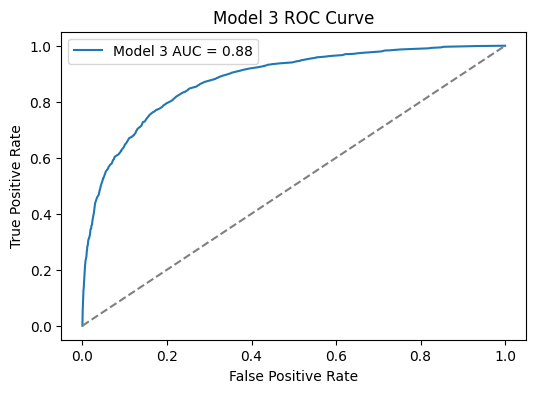

In [4]:
y = churn['Exited']
X = churn.drop(columns='Exited')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2025)

# Encoding of categorical features
cat_cols = ['Gender', 'HasCrCard', 'IsActiveMember']
le = LabelEncoder()
for col in cat_cols:
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])

# List of parameter sets to compare
param_grid = [
    {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 4},
    {'n_estimators': 150, 'learning_rate': 0.05, 'max_depth': 5},
    {'n_estimators': 200, 'learning_rate': 0.01, 'max_depth': 3},
]

# Iteration
for i, params in enumerate(param_grid, 1):
    print(f"\n=== Model {i} Parameters: {params} ===")
    
    model = XGBClassifier(
        **params,
        scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=2025
    )
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # metrics
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Churn', 'Churn'],
                yticklabels=['No Churn', 'Churn'])
    plt.title(f'Model {i} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'Model {i} AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title(f'Model {i} ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()


### ✅ Best Model: Model 1

* **Params:** `{'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 4}`
* **Accuracy:** 81%
* **F1-score (Churn class 1):** 0.62
* **ROC-AUC:** **0.877** ← best among the three

Ce modèle offre le meilleur équilibre entre **rappel**, **score f1** et **ROC-AUC** pour la classe positive (churners).

In [5]:
# Final model with best parameters
best_xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=2025
)

best_xgb_model.fit(X_train, y_train)


/Users/eric/Documents/Formation/ML_School/Projets/projet_Bank_Churn/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:16:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


# SHAP Analysis

Dans cette section, nous utiliserons le package ` shap ` (SHapley Additive exPlanations) pour interpréter et expliquer les prédictions générées par notre modèle de prédiction du taux de désabonnement. SHAP fournit une mesure unifiée de l'importance des caractéristiques en quantifiant la contribution de chaque variable aux prédictions individuelles. Notre objectif principal est d'identifier les caractéristiques clés qui influencent les prédictions du modèle, en nous concentrant plus particulièrement sur les variables qui influencent significativement le taux de désabonnement d'un client. Cette analyse nous aidera à mieux comprendre les facteurs qui influencent le taux de désabonnement et à prendre des décisions plus éclairées en matière de stratégies de fidélisation.

In [6]:
import shap

explainer = shap.Explainer(best_xgb_model, X_train)
shap_values = explainer(X_test)


/Users/eric/Documents/Formation/ML_School/Projets/projet_Bank_Churn/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|===================| 28674/28716 [01:58<00:00]        

In [7]:
np.shape(shap_values.values) # (Num. of observations, Num. of shap values)

(28716, 11)

11 SHAP values for each of the observations in our dataset

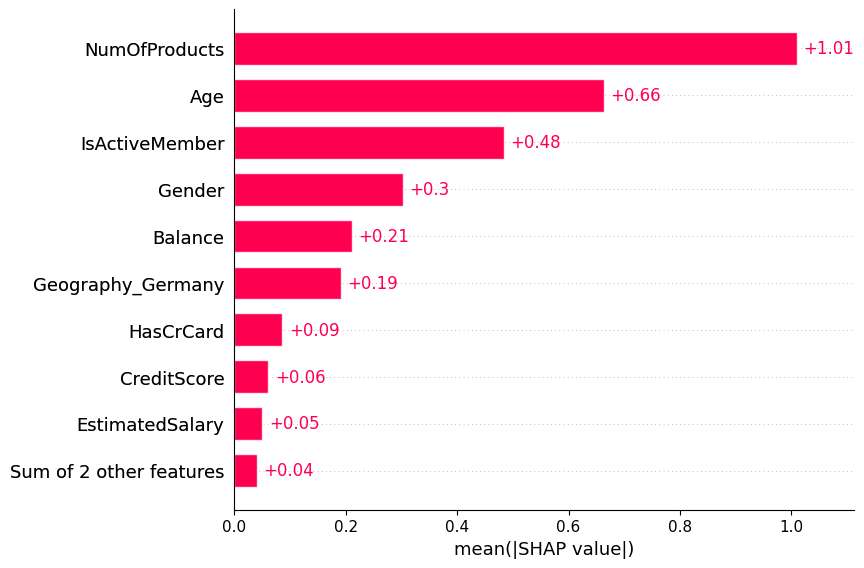

In [8]:
shap.plots.bar(shap_values)

Ces variables représentent les valeurs SHAP absolues moyennes pour toutes les observations. Les caractéristiques dont les valeurs sont les plus élevées ont une influence globale plus importante sur les prédictions du modèle. Les caractéristiques les plus impactantes sont `Âge`, `NombreDeProduits` et `MembreActive`, dans cet ordre. Cependant, pour comprendre si ces variables influencent les prédictions de désabonnement ou de rétention, nous devons examiner la direction de leurs valeurs SHAP (positives ou négatives) selon les différents points de données.

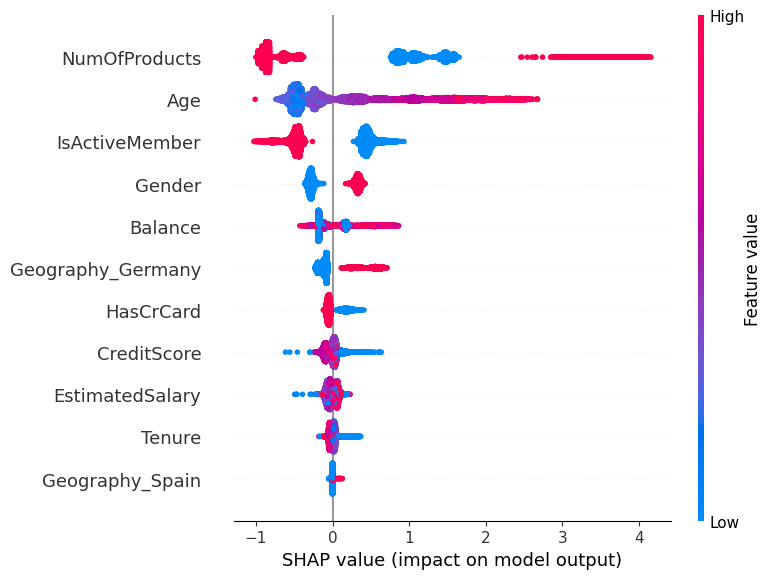

In [9]:
shap.summary_plot(shap_values, X_test)

Il est intéressant de constater que les clients plus âgés ont tendance à être plus susceptibles de quitter le service. Une tendance curieuse se dessine concernant le nombre de produits : généralement, avoir plus de produits est associé à un risque de désabonnement plus faible, mais nous observons également des cas où un nombre élevé de produits correspond à des valeurs SHAP plus élevées pour cette caractéristique, indiquant un risque de désabonnement accru. Comme prévu, les membres actifs sont moins susceptibles de quitter le service. Autre constat notable : les hommes sont plus enclins à la désabonnement que les femmes, ce qui concorde avec ce que nous avons observé précédemment lors de l’analyse exploratoire des données (première partie).

L’anomalie selon laquelle un nombre élevé de produits réduit généralement le risque de désabonnement, mais entraîne parfois des valeurs SHAP plus élevées (indiquant un risque de désabonnement accru) pourrait être due à des effets d’interaction ou à des valeurs aberrantes dans les données. Par exemple :

* **Interactions avec d’autres caractéristiques :** Dans certains cas, avoir de nombreux produits peut être lié à d’autres facteurs augmentant le risque de désabonnement (par exemple, insatisfaction à l’égard du produit, complexité de la gestion de nombreux produits ou expériences négatives récentes). Les valeurs SHAP reflètent les contributions des caractéristiques dans le contexte du modèle global. Ainsi, si d'autres caractéristiques signalent un risque élevé, la caractéristique « nombre de produits ` peut parfois également contribuer positivement à l'attrition.

* **Valeurs aberrantes ou segments spécifiques :** Il peut exister un sous-ensemble de clients possédant de nombreux produits, mais qui s'attristent malgré tout pour des raisons spécifiques non prises en compte par le seul nombre de produits, comme un service client médiocre ou des offres concurrentielles.

* **Effets non linéaires :** La relation entre le nombre de produits et l'attrition peut ne pas être strictement linéaire. Par exemple, jusqu'à un certain point, un plus grand nombre de produits réduit l'attrition, mais au-delà d'un certain seuil, l'effet s'inverse.

Afin d'explorer ce phénomène, nous pouvons imprimer un graphique de dépendance avec d'autres variables pour identifier les interactions.

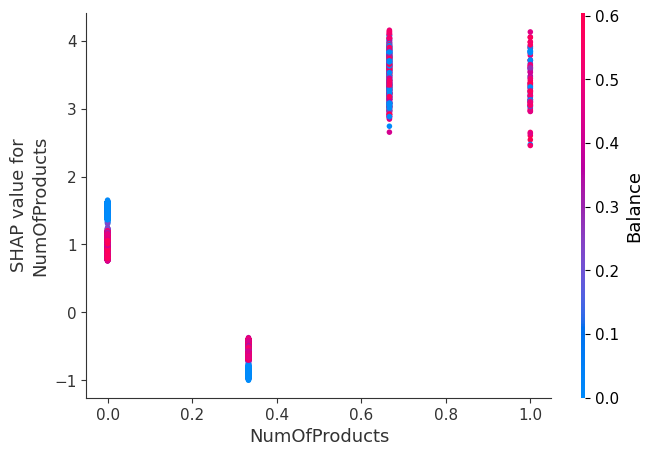

In [10]:
shap.dependence_plot('NumOfProducts', shap_values.values, X_test)


Le graphique de dépendance révèle une interaction avec la variable `Solde`. Il montre que les clients possédant à la fois un nombre élevé de produits et un solde de compte élevé ont tendance à avoir une probabilité accrue de désabonnement, selon les prédictions du modèle.

Nous pouvons également vérifier les autres dépendances détectées par le modèle :

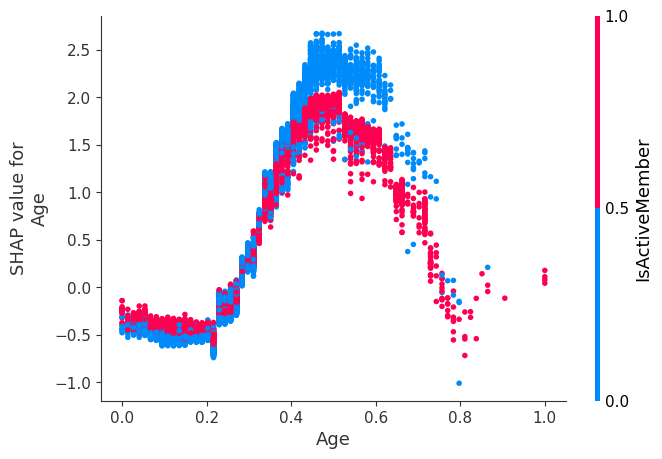

In [11]:
shap.dependence_plot('Age', shap_values.values, X_test)

Cette fois, en nous concentrant sur la variable la plus influente, nous observons que son interaction la plus forte est avec `IsActiveMember`, la troisième caractéristique la plus importante. Le graphique indique que les clients inactifs et d'âge moyen (environ 0,5 ans après normalisation) présentent une probabilité plus élevée de désabonnement.

### Conclusions

* **L'âge est le facteur dominant** : les clients plus âgés présentent un risque de désabonnement plus élevé, notamment en cas d'inactivité, ce qui accroît leur probabilité de départ. Cela met en évidence un segment vulnérable qui nécessite une attention particulière.

* **Le nombre de produits révèle une situation plus nuancée** : si généralement, avoir plus de produits est corrélé à un faible taux de désabonnement, nous avons constaté une anomalie : certains clients possédant de nombreux produits présentent néanmoins un risque de désabonnement élevé. L'interaction entre ` NumOfProducts ` et ` Balance ` indique que les clients possédant de nombreux produits et ayant un solde élevé sont, de manière inattendue, plus susceptibles de quitter leur compte. Cette anomalie importante justifie un suivi qualitatif (par exemple, des enquêtes ou des entretiens) pour en identifier les causes profondes.

* **Le statut d'activité (`IsActiveMember`) modère fortement le taux de désabonnement** : les membres inactifs sont à l'origine d'une grande partie du taux de désabonnement, le risque le plus élevé étant celui des membres inactifs et plus âgés. Cette interaction est un facteur clé de désabonnement et une cible privilégiée pour les efforts de réengagement.

* **Les différences géographiques sont importantes** : les clients allemands présentent un risque de désabonnement élevé, ce qui indique des facteurs régionaux ou des problématiques spécifiques au marché qui affectent la fidélité.

* **D'autres variables (sexe, score de crédit, salaire estimé) ont une influence plus faible, mais non négligeable** : ces facteurs peuvent néanmoins contribuer de manière marginale et améliorer l'affinement du modèle ou les stratégies de segmentation.

---

### Actions recommandées

1. **Stratégies de fidélisation segmentées** :

* Priorisation des clients inactifs plus âgés pour une communication et des incitations personnalisées.
* Étude des clients multi-produits et à solde élevé afin d'identifier les points faibles : la simplification des produits, les offres groupées ou un support dédié pourraient constituer des solutions d'atténuation.

2. **Engagement client renforcé** :

* Développement de programmes de réactivation des membres inactifs, en s'appuyant sur des informations sur l'âge et la géographie.
* Communication personnalisée pour les clients allemands, tenant compte des préférences ou des préoccupations locales.

3. **Analyse approfondie des anomalies** :

* Réalisation d'études qualitatives (par exemple, entretiens, groupes de discussion) ciblant les clients qui défient les tendances générales, comme ceux qui possèdent de nombreux produits mais présentent un risque élevé de désabonnement, afin de comprendre les facteurs d'insatisfaction.

4. **Objectif régional : l'Allemagne** :

* Réalisation d'une analyse approfondie de l'expérience client et de la concurrence en Allemagne.
* Introduction de promotions locales ou d'améliorations de service dans cette zone géographique.

In [12]:
# Chargement des données de test
test_data = pd.read_csv("../data/test_data_à_predire.csv", index_col="ID")

# Affichage des premières lignes pour comprendre la structure
print("Structure des données de test:")
print(test_data.head())
print(f"\nShape: {test_data.shape}")
print(f"\nColonnes: {test_data.columns.tolist()}")



Structure des données de test:
        CustomerId    Surname  CreditScore Geography  Gender   Age  Tenure  \
ID                                                                           
67897     15585246     Bancks          585    France  Female  53.0       2   
163075    15604551       Robb          606    France    Male  24.0       2   
134760    15729040  Ugochukwu          633   Germany    Male  44.0       1   
68707     15792329        Hs?          602   Germany    Male  40.0       2   
3428      15617166   Genovesi          645    France    Male  31.0       4   

          Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  
ID                                                                            
67897        0.00              2        1.0             1.0         91830.75  
163075       0.00              1        0.0             1.0         90876.95  
134760  118907.60              1        1.0             0.0         47777.15  
68707   149961.99          

In [13]:
# Préparation des données de test (même preprocessing que pour les données d'entraînement)
test_processed = test_data.copy()
test_processed.drop(columns=['CustomerId'], inplace=True, errors='ignore')  # Suppression de CustomerId si elle existe

# Suppression de la colonne Surname si elle existe
if 'Surname' in test_processed.columns:
    test_processed = test_processed.drop(["Surname"], axis=1)

# Encodage du genre
test_processed['Gender'] = test_processed['Gender'].map({'Male': 0, 'Female': 1})

# One-hot encoding pour Geography
test_processed = pd.get_dummies(test_processed, columns=['Geography'], drop_first=True, dtype=int)

# Conversion en catégories
categorical_cols = ['HasCrCard', 'IsActiveMember', 'Gender']
for col in categorical_cols:
    if col in test_processed.columns:
        test_processed[col] = test_processed[col].astype('category')

# Normalisation avec le même scaler utilisé pour l'entraînement
# Note: Nous devons utiliser le même scaler que celui utilisé pour les données d'entraînement
num_cols = test_processed.select_dtypes(include='number').columns
test_processed[num_cols] = scaler.transform(test_processed[num_cols])

print("Données de test après preprocessing:")
print(test_processed.head())

Données de test après preprocessing:
        CreditScore Gender       Age  Tenure   Balance  NumOfProducts  \
ID                                                                      
67897         0.470      1  0.472973     0.2  0.000000       0.333333   
163075        0.512      0  0.081081     0.2  0.000000       0.000000   
134760        0.566      0  0.351351     0.1  0.473928       0.000000   
68707         0.504      0  0.297297     0.2  0.597701       0.333333   
3428          0.590      0  0.175676     0.4  0.527510       0.000000   

       HasCrCard IsActiveMember  EstimatedSalary  Geography_Germany  \
ID                                                                    
67897        1.0            1.0         0.459140                0.0   
163075       0.0            1.0         0.454370                0.0   
134760       1.0            0.0         0.238851                1.0   
68707        1.0            1.0         0.413466                1.0   
3428         1.0         

In [14]:
# Encodage des variables catégorielles avec LabelEncoder
# Nous devons nous assurer que les colonnes correspondent à celles du modèle
cat_cols_test = ['Gender', 'HasCrCard', 'IsActiveMember']
test_encoded = test_processed.copy()

for col in cat_cols_test:
    if col in test_encoded.columns:
        test_encoded[col] = le.fit_transform(test_encoded[col])

# Vérification que les colonnes correspondent à celles utilisées pour l'entraînement
print("Colonnes dans les données d'entraînement:", X_train.columns.tolist())
print("Colonnes dans les données de test:", test_encoded.columns.tolist())

# Réorganisation des colonnes pour qu'elles correspondent
if 'ID' in test_encoded.columns:
    customer_ids = test_data['ID']  # Garder les IDs originaux
    test_features = test_encoded.drop('ID', axis=1)
else:
    customer_ids = test_data.index
    test_features = test_encoded

# S'assurer que les colonnes sont dans le même ordre que X_train
test_features = test_features.reindex(columns=X_train.columns, fill_value=0)

print(f"\nShape finale des données de test: {test_features.shape}")

Colonnes dans les données d'entraînement: ['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain']
Colonnes dans les données de test: ['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain']

Shape finale des données de test: (21455, 11)


In [15]:
# Prédiction avec le modèle XGBoost optimisé
# Prédiction des probabilités
y_pred_proba = best_xgb_model.predict_proba(test_features)[:, 1]

# Prédiction des classes (optionnel)
y_pred_class = best_xgb_model.predict(test_features)

print(f"Nombre de prédictions: {len(y_pred_proba)}")
print(f"Exemple de probabilités (5 premières): {y_pred_proba[:5]}")
print(f"Distribution des prédictions de classe: {np.bincount(y_pred_class)}")

Nombre de prédictions: 21455
Exemple de probabilités (5 premières): [0.29733095 0.3313043  0.8764509  0.18495765 0.2802842 ]
Distribution des prédictions de classe: [14715  6740]


In [16]:
# Création du fichier de soumission
submission = pd.DataFrame({
    'ID': customer_ids,
    'Exited': y_pred_class  # Utilisation des probabilités pour une soumission plus nuancée
})

# Affichage des premières lignes
print("Fichier de soumission:")
print(submission.head(10))


# Statistiques descriptives
print(f"\nStatistiques des prédictions:")
print(f"Distribution des prédictions:")
print(submission['Exited'].value_counts().sort_index())
print(f"Proportion de churn prédit: {submission['Exited'].mean():.4f}")

# Sauvegarde du fichier
submission.to_csv('../submission_xgboost_final.csv', index=False)
print(f"\nFichier de soumission sauvegardé: '../submission_xgboost_final.csv'")

Fichier de soumission:


       ID  Exited
0   67897       0
1  163075       0
2  134760       1
3   68707       0
4    3428       0
5  107265       1
6  158447       0
7   80740       1
8  125044       1
9  154966       1

Statistiques des prédictions:
Distribution des prédictions:
Exited
0    14715
1     6740
Name: count, dtype: int64
Proportion de churn prédit: 0.3141

Fichier de soumission sauvegardé: '../submission_xgboost_final.csv'


In [17]:
# Vérification finale du fichier créé
verification = pd.read_csv('../submission_xgboost_final.csv')
print("Vérification du fichier créé:")
print(verification.head())
print(f"Shape: {verification.shape}")
print(f"Colonnes: {verification.columns.tolist()}")

# Vérification qu'il n'y a pas de valeurs manquantes
print(f"\nValeurs manquantes: {verification.isnull().sum()}")

# Vérification que toutes les valeurs sont bien 0 ou 1
print(f"\nValeurs uniques dans 'Exited': {sorted(verification['Exited'].unique())}")

Vérification du fichier créé:
       ID  Exited
0   67897       0
1  163075       0
2  134760       1
3   68707       0
4    3428       0
Shape: (21455, 2)
Colonnes: ['ID', 'Exited']

Valeurs manquantes: ID        0
Exited    0
dtype: int64

Valeurs uniques dans 'Exited': [np.int64(0), np.int64(1)]
